In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from super_gradients.training import Trainer
from super_gradients.training import models

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

The console stream is logged into /root/sg_logs/console.log


[2023-05-08 04:41:11] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-05-08 04:41:22] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-08 04:41:22] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-08 04:41:22] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-08 04:41:22] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [9]:
# dataset_params = {
#     'data_dir':'/content/drive/MyDrive/bdd100k_small',
#     'train_images_dir':'train/images',
#     'train_labels_dir':'train/labels',
#     'val_images_dir':'valid/images',
#     'val_labels_dir':'valid/labels',
#     'test_images_dir':'test/images',
#     'test_labels_dir':'test/labels',
#     'classes': ['Dime', 'Nickel', 'Penny', 'Quarter']
# }

dataset_params = {
    'data_dir':'/content/drive/MyDrive/bdd100k',
    'train_images_dir':'images/train',
    'train_labels_dir':'labels/train',
    'val_images_dir':'images/val',
    'val_labels_dir':'labels/val',
    'test_images_dir':'images/test',
    'classes': ['pedestrian', 'rider', 'car', 'truck', 'bus',
                'train', 'motorcycle', 'bicycle',
                'traffic light', 'traffic sign']
}

In [10]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

OSError: ignored

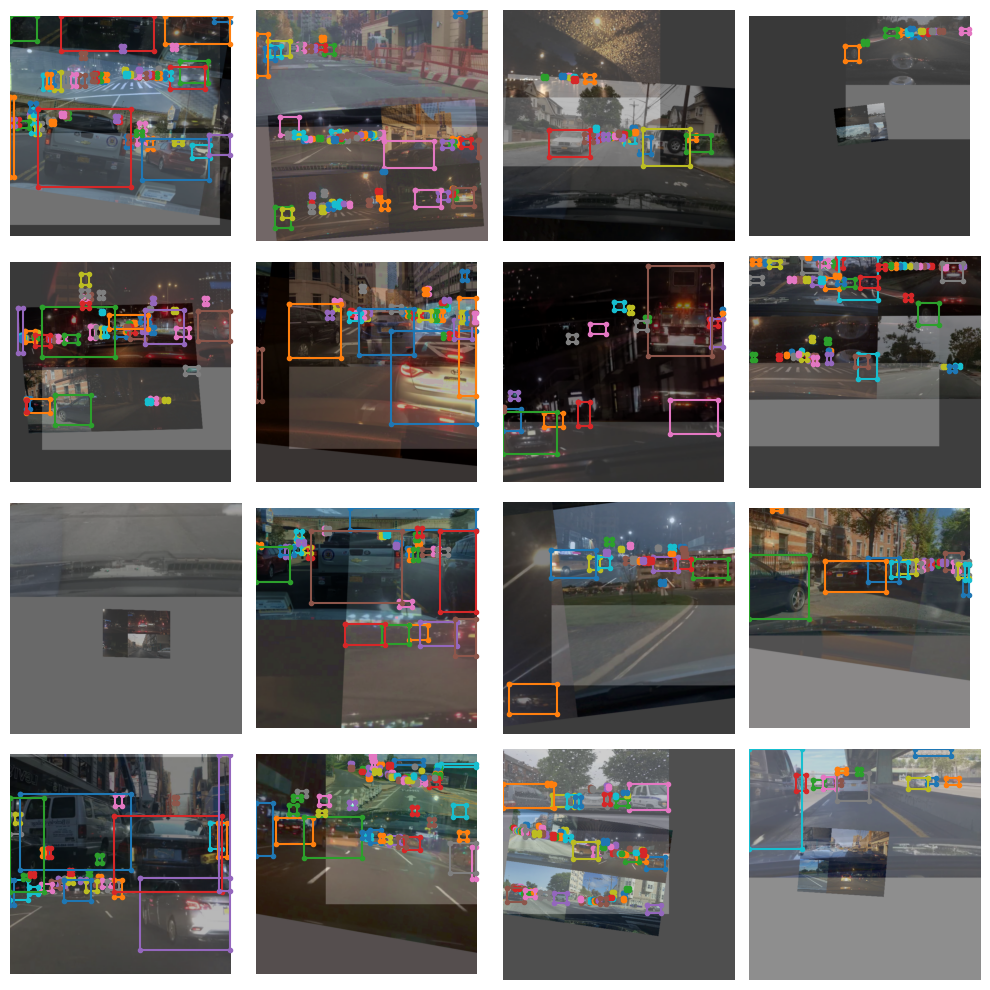

In [5]:
train_data.dataset.plot()

In [6]:
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-08 04:42:31] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


  0%|          | 0.00/256M [00:00<?, ?B/s]

In [7]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [8]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-08 04:42:45] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-05-08 04:42:52] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints/my_first_yolonas_run/console_May08_04_42_52.txt


[2023-05-08 04:43:01] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 104        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         6          (len(train_loader))
    - Gradient updates per epoch:   6          (len(train_loader) / batch_accumulate)

[2023-05-08 04:43:01] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validation epoch 0: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.7146
│   ├── Ppyoloeloss/loss_cls = 2.2739
│   ├── Ppyoloeloss/loss_dfl = 1.2541
│   └── Ppyoloeloss/loss_iou = 0.3255
└── Validation
    ├── F1@0.50 = 0.0
    ├── Map@0.50 = 0.0
    ├── Ppyoloeloss/loss = 3.6195
    ├── Ppyoloeloss/loss_cls = 2.4729
    ├── Ppyoloeloss/loss_dfl = 0.9964
    ├── Ppyoloeloss/loss_iou = 0.2594
    ├── Precision@0.50 = 0.0
    └── Recall@0.50 = 0.0



[2023-05-08 04:43:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-08 04:43:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0
Validation epoch 1: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 3.0471
│   │   ├── Best until now = 3.7146 (↘ -0.6675)
│   │   └── Epoch N-1      = 3.7146 (↘ -0.6675)
│   ├── Ppyoloeloss/loss_cls = 1.7214
│   │   ├── Best until now = 2.2739 (↘ -0.5524)
│   │   └── Epoch N-1      = 2.2739 (↘ -0.5524)
│   ├── Ppyoloeloss/loss_dfl = 1.0749
│   │   ├── Best until now = 1.2541 (↘ -0.1792)
│   │   └── Epoch N-1      = 1.2541 (↘ -0.1792)
│   └── Ppyoloeloss/loss_iou = 0.3153
│       ├── Best until now = 0.3255 (↘ -0.0102)
│       └── Epoch N-1      = 0.3255 (↘ -0.0102)
└── Validation
    ├── F1@0.50 = 0.0153
    │   ├── Best until now = 0.0    (↗ 0.0153)
    │   └── Epoch N-1      = 0.0    (↗ 0.0153)
    ├── Map@0.50 = 0.0341
    │   ├── Best until now = 0.0    (↗ 0.0341)
    │   └── Epoch N-1      = 0.0    (↗ 0.0341)
    ├── Ppyoloeloss/loss = 4.3282
    │   ├── Best until now = 3.6195 (↗ 0.7087)
    │   └── Epoch N-1      = 3.6195 (↗ 0.7087)
    ├── Ppyoloeloss/loss_cls = 3.2037
    │   ├── Best

[2023-05-08 04:44:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-08 04:44:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.034078605473041534
Validation epoch 2: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 2.4853
│   │   ├── Best until now = 3.0471 (↘ -0.5618)
│   │   └── Epoch N-1      = 3.0471 (↘ -0.5618)
│   ├── Ppyoloeloss/loss_cls = 1.2038
│   │   ├── Best until now = 1.7214 (↘ -0.5176)
│   │   └── Epoch N-1      = 1.7214 (↘ -0.5176)
│   ├── Ppyoloeloss/loss_dfl = 1.0193
│   │   ├── Best until now = 1.0749 (↘ -0.0555)
│   │   └── Epoch N-1      = 1.0749 (↘ -0.0555)
│   └── Ppyoloeloss/loss_iou = 0.3087
│       ├── Best until now = 0.3153 (↘ -0.0066)
│       └── Epoch N-1      = 0.3153 (↘ -0.0066)
└── Validation
    ├── F1@0.50 = 0.0099
    │   ├── Best until now = 0.0153 (↘ -0.0054)
    │   └── Epoch N-1      = 0.0153 (↘ -0.0054)
    ├── Map@0.50 = 0.0031
    │   ├── Best until now = 0.0341 (↘ -0.031)
    │   └── Epoch N-1      = 0.0341 (↘ -0.031)
    ├── Ppyoloeloss/loss = 5.0639
    │   ├── Best until now = 3.6195 (↗ 1.4444)
    │   └── Epoch N-1      = 4.3282 (↗ 0.7357)
    ├── Ppyoloeloss/loss_cls = 2.9144
    │   ├── Be

Validation epoch 3: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 2.3973
│   │   ├── Best until now = 2.4853 (↘ -0.088)
│   │   └── Epoch N-1      = 2.4853 (↘ -0.088)
│   ├── Ppyoloeloss/loss_cls = 1.0991
│   │   ├── Best until now = 1.2038 (↘ -0.1047)
│   │   └── Epoch N-1      = 1.2038 (↘ -0.1047)
│   ├── Ppyoloeloss/loss_dfl = 1.0529
│   │   ├── Best until now = 1.0193 (↗ 0.0336)
│   │   └── Epoch N-1      = 1.0193 (↗ 0.0336)
│   └── Ppyoloeloss/loss_iou = 0.3087
│       ├── Best until now = 0.3087 (↘ -0.0)
│       └── Epoch N-1      = 0.3087 (↘ -0.0)
└── Validation
    ├── F1@0.50 = 0.0042
    │   ├── Best until now = 0.0153 (↘ -0.0112)
    │   └── Epoch N-1      = 0.0099 (↘ -0.0058)
    ├── Map@0.50 = 0.0016
    │   ├── Best until now = 0.0341 (↘ -0.0325)
    │   └── Epoch N-1      = 0.0031 (↘ -0.0014)
    ├── Ppyoloeloss/loss = 6.0429
    │   ├── Best until now = 3.6195 (↗ 2.4234)
    │   └── Epoch N-1      = 5.0639 (↗ 0.979)
    ├── Ppyoloeloss/loss_cls = 3.5276
    │   ├── Best until 

Validation epoch 4: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 2.2956
│   │   ├── Best until now = 2.3973 (↘ -0.1017)
│   │   └── Epoch N-1      = 2.3973 (↘ -0.1017)
│   ├── Ppyoloeloss/loss_cls = 1.0593
│   │   ├── Best until now = 1.0991 (↘ -0.0399)
│   │   └── Epoch N-1      = 1.0991 (↘ -0.0399)
│   ├── Ppyoloeloss/loss_dfl = 1.0272
│   │   ├── Best until now = 1.0193 (↗ 0.0079)
│   │   └── Epoch N-1      = 1.0529 (↘ -0.0257)
│   └── Ppyoloeloss/loss_iou = 0.2891
│       ├── Best until now = 0.3087 (↘ -0.0196)
│       └── Epoch N-1      = 0.3087 (↘ -0.0196)
└── Validation
    ├── F1@0.50 = 0.0186
    │   ├── Best until now = 0.0153 (↗ 0.0033)
    │   └── Epoch N-1      = 0.0042 (↗ 0.0144)
    ├── Map@0.50 = 0.0128
    │   ├── Best until now = 0.0341 (↘ -0.0213)
    │   └── Epoch N-1      = 0.0016 (↗ 0.0111)
    ├── Ppyoloeloss/loss = 117.939
    │   ├── Best until now = 3.6195 (↗ 114.3195)
    │   └── Epoch N-1      = 6.0429 (↗ 111.8961)
    ├── Ppyoloeloss/loss_cls = 116.4428
    │   ├

Validation epoch 5: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 2.2224
│   │   ├── Best until now = 2.2956 (↘ -0.0731)
│   │   └── Epoch N-1      = 2.2956 (↘ -0.0731)
│   ├── Ppyoloeloss/loss_cls = 1.0376
│   │   ├── Best until now = 1.0593 (↘ -0.0216)
│   │   └── Epoch N-1      = 1.0593 (↘ -0.0216)
│   ├── Ppyoloeloss/loss_dfl = 1.0049
│   │   ├── Best until now = 1.0193 (↘ -0.0144)
│   │   └── Epoch N-1      = 1.0272 (↘ -0.0223)
│   └── Ppyoloeloss/loss_iou = 0.2729
│       ├── Best until now = 0.2891 (↘ -0.0161)
│       └── Epoch N-1      = 0.2891 (↘ -0.0161)
└── Validation
    ├── F1@0.50 = 0.0003
    │   ├── Best until now = 0.0186 (↘ -0.0182)
    │   └── Epoch N-1      = 0.0186 (↘ -0.0182)
    ├── Map@0.50 = 0.0
    │   ├── Best until now = 0.0341 (↘ -0.0341)
    │   └── Epoch N-1      = 0.0128 (↘ -0.0127)
    ├── Ppyoloeloss/loss = 3643.4253
    │   ├── Best until now = 3.6195 (↗ 3639.806)
    │   └── Epoch N-1      = 117.939 (↗ 3525.4863)
    ├── Ppyoloeloss/loss_cls = 3640.9956
   

Validation epoch 6: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 2.2215
│   │   ├── Best until now = 2.2224 (↘ -0.0009)
│   │   └── Epoch N-1      = 2.2224 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_cls = 1.0337
│   │   ├── Best until now = 1.0376 (↘ -0.0039)
│   │   └── Epoch N-1      = 1.0376 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.9816
│   │   ├── Best until now = 1.0049 (↘ -0.0233)
│   │   └── Epoch N-1      = 1.0049 (↘ -0.0233)
│   └── Ppyoloeloss/loss_iou = 0.2788
│       ├── Best until now = 0.2729 (↗ 0.0058)
│       └── Epoch N-1      = 0.2729 (↗ 0.0058)
└── Validation
    ├── F1@0.50 = 0.0053
    │   ├── Best until now = 0.0186 (↘ -0.0133)
    │   └── Epoch N-1      = 0.0003 (↗ 0.005)
    ├── Map@0.50 = 0.0009
    │   ├── Best until now = 0.0341 (↘ -0.0332)
    │   └── Epoch N-1      = 0.0    (↗ 0.0009)
    ├── Ppyoloeloss/loss = 2167.9907
    │   ├── Best until now = 3.6195 (↗ 2164.3713)
    │   └── Epoch N-1      = 3643.4253 (↘ -1475.4346)
    ├── Ppyoloeloss/loss_cls = 2166.637
  

Validation epoch 7: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 2.0985
│   │   ├── Best until now = 2.2215 (↘ -0.123)
│   │   └── Epoch N-1      = 2.2215 (↘ -0.123)
│   ├── Ppyoloeloss/loss_cls = 0.9715
│   │   ├── Best until now = 1.0337 (↘ -0.0622)
│   │   └── Epoch N-1      = 1.0337 (↘ -0.0622)
│   ├── Ppyoloeloss/loss_dfl = 0.952
│   │   ├── Best until now = 0.9816 (↘ -0.0296)
│   │   └── Epoch N-1      = 0.9816 (↘ -0.0296)
│   └── Ppyoloeloss/loss_iou = 0.2604
│       ├── Best until now = 0.2729 (↘ -0.0125)
│       └── Epoch N-1      = 0.2788 (↘ -0.0184)
└── Validation
    ├── F1@0.50 = 0.018
    │   ├── Best until now = 0.0186 (↘ -0.0006)
    │   └── Epoch N-1      = 0.0053 (↗ 0.0126)
    ├── Map@0.50 = 0.0133
    │   ├── Best until now = 0.0341 (↘ -0.0208)
    │   └── Epoch N-1      = 0.0009 (↗ 0.0125)
    ├── Ppyoloeloss/loss = 166.7366
    │   ├── Best until now = 3.6195 (↗ 163.1171)
    │   └── Epoch N-1      = 2167.9907 (↘ -2001.2542)
    ├── Ppyoloeloss/loss_cls = 165.5996
    │

Validation epoch 8: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 2.0784
│   │   ├── Best until now = 2.0985 (↘ -0.0202)
│   │   └── Epoch N-1      = 2.0985 (↘ -0.0202)
│   ├── Ppyoloeloss/loss_cls = 0.9604
│   │   ├── Best until now = 0.9715 (↘ -0.0112)
│   │   └── Epoch N-1      = 0.9715 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.9437
│   │   ├── Best until now = 0.952  (↘ -0.0083)
│   │   └── Epoch N-1      = 0.952  (↘ -0.0083)
│   └── Ppyoloeloss/loss_iou = 0.2585
│       ├── Best until now = 0.2604 (↘ -0.0019)
│       └── Epoch N-1      = 0.2604 (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.0249
    │   ├── Best until now = 0.0186 (↗ 0.0063)
    │   └── Epoch N-1      = 0.018  (↗ 0.007)
    ├── Map@0.50 = 0.0415
    │   ├── Best until now = 0.0341 (↗ 0.0075)
    │   └── Epoch N-1      = 0.0133 (↗ 0.0282)
    ├── Ppyoloeloss/loss = 3.9553
    │   ├── Best until now = 3.6195 (↗ 0.3359)
    │   └── Epoch N-1      = 166.7366 (↘ -162.7813)
    ├── Ppyoloeloss/loss_cls = 2.8763
    │   ├── 

[2023-05-08 04:48:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-08 04:48:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.04154427349567413
Validation epoch 9: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 2.017
│   │   ├── Best until now = 2.0784 (↘ -0.0614)
│   │   └── Epoch N-1      = 2.0784 (↘ -0.0614)
│   ├── Ppyoloeloss/loss_cls = 0.9407
│   │   ├── Best until now = 0.9604 (↘ -0.0196)
│   │   └── Epoch N-1      = 0.9604 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_dfl = 0.8921
│   │   ├── Best until now = 0.9437 (↘ -0.0516)
│   │   └── Epoch N-1      = 0.9437 (↘ -0.0516)
│   └── Ppyoloeloss/loss_iou = 0.2521
│       ├── Best until now = 0.2585 (↘ -0.0064)
│       └── Epoch N-1      = 0.2585 (↘ -0.0064)
└── Validation
    ├── F1@0.50 = 0.0267
    │   ├── Best until now = 0.0249 (↗ 0.0018)
    │   └── Epoch N-1      = 0.0249 (↗ 0.0018)
    ├── Map@0.50 = 0.0624
    │   ├── Best until now = 0.0415 (↗ 0.0209)
    │   └── Epoch N-1      = 0.0415 (↗ 0.0209)
    ├── Ppyoloeloss/loss = 2.6949
    │   ├── Best until now = 3.6195 (↘ -0.9246)
    │   └── Epoch N-1      = 3.9553 (↘ -1.2604)
    ├── Ppyoloeloss/loss_cls = 1.649
    │   ├── Best

[2023-05-08 04:49:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-05-08 04:49:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.06242017075419426
[2023-05-08 04:49:32] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 10: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]
